# Image Feature Extraction and Scene Matching Technique Exploration

This notebook explores different methods of feature extraction and scene matching for images using OpenCV

### Install OpenCV

In [1]:
!pip install opencv-python


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import cv2
import numpy as np

## Brute Force with Sift and K Nearest Neighbors

### Apply SIFT to extract features

Scale Invariant Feature Transform (SIFT) is a feature extraction algorithms for images.   It works to reduce the dimensions of the feature space by identifying the truly unique, identifying pixels of the image

 - [Introduction to SIFT (Scale-Invariant Feature Transform)](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)
 - [What is SIFT](https://www.educative.io/answers/what-is-sift)
 - [SIFT](https://www.cse.iitb.ac.in/~ajitvr/CS763/SIFT.pdf)

In [3]:
# Load Images
img1 = cv2.imread('images/box.png',cv2.IMREAD_GRAYSCALE) # queryImage
img2 = cv2.imread('images/box_in_scene.png',cv2.IMREAD_GRAYSCALE) # trainImage

In [4]:
# Find the keypoints and descriptors with SIFT
# Here kp will be a list of keypoints and des is a numpy array of shape (Number of Keypoints) x 128.  These will represent the features of te image
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

## Apply K Nearest Neighbors

The K-Nearest Neighbors (KNN) algorithm is a supervised machine learning method employed to tackle classification and regression problems.  In this case, it's being used to determine for each feature keypoint in the scene, what is the closest match to the points in the image feature space.  

 - [Understanding k-Nearest Neighbour](https://docs.opencv.org/4.x/d5/d26/tutorial_py_knn_understanding.html)
 - [K-Nearest Neighbor Matching](https://lost-stats.github.io/Machine_Learning/Nearest_Neighbor.html)

In [5]:
# Find matches using k nearest neighbors
# https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

#### Apply Lowe's ratio test to threshold the best matches.  

To keep only the strong matches we will use David Lowe’s ratio test. Lowe proposed this ratio test in order to increase the robustness of the SIFT algorithm. The goal of this test is to get rid of the points that are not distinct enough. The general idea is that there needs to be enough difference between the first best match and the second-best matches.

The code below iterates through the list of matches.  Each match is a tuple of the nearest neighbor (best match) and the second nearest neighbor (second-best match) (because k=2 was used above).  

In [6]:
good = []
for k_one, k_two in matches:
    if k_one.distance < 0.75 * k_two.distance:
        good.append([k_one])

In [7]:
# Draw the matches
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imshow("image", img3)
cv2.waitKey()
cv2.destroyAllWindows()

# Brute Force with ORB and Hamming Distance
Oriented Fast and Rotated Brief (ORB) - ORB originated directly from "OpenCV Labs". This algorithm was brought up by Ethan Rublee, Vincent Rabaud, Kurt Konolige and Gary R. Bradski in their paper ORB: An efficient alternative to SIFT or SURF in 2011. As the title says, it is a good alternative to SIFT and SURF in computation cost, matching performance and mainly the patents. Yes, SIFT and SURF are patented and you are supposed to pay them for its use. But ORB is not !!!

ORB based on the [FAST keypoint detector](https://en.wikipedia.org/wiki/Features_from_accelerated_segment_test) and a modified version of the visual descriptor [BRIEF (Binary Robust Independent Elementary Features)](https://en.wikipedia.org/w/index.php?title=BRIEF&action=edit&redlink=1)

ORB produces a binary descriptor, or a descriptor in the form of a binary string.  See [this blog](https://gilscvblog.com/2013/10/04/a-tutorial-on-binary-descriptors-part-3-the-orb-descriptor/) and [this article](https://medium.com/@deepanshut041/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf) for more info 

[ORB (Oriented FAST and Rotated BRIEF)](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html)

## Apply ORB to Extract Features 

In [8]:
# Find the keypoints and descriptors with ORB
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

## Apply Hamming Distance

Recall that the ORB feature extraction algorithm produces a binary descriptor in the form of a binary string.  The Hamming Distance between two strings or vectors is the number of positions at which the corresponding symbols are different.  In other words, it measures the minimum number of substitutions required to change one string into the other.  It can be used here to find the distance between the original image and the scene image

In [9]:
# Because ORB is a binary descriptor, we find matches using Hamming Distance, which is a measure of the difference between two strings of equal length.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Sort by distances found to identify the best matches
matches = sorted(matches, key=lambda x: x.distance)

In [10]:
# Draw the first 10 matches
img3 = cv2.drawMatches(
    img1,
    kp1,
    img2,
    kp2,
    matches[:10], # ten closest matcvhes
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)
cv2.imshow("image", img3)
cv2.waitKey()
cv2.destroyAllWindows()


# SIFT with Fast Library for Approximate Nearest Neighbors (FLANN)
FLANN is an algorithm for performing fast approximate nearest neighbor searches in high dimensional spaces.  It's an alternative to K-Nearest Neighbor search used above.

It contains a collection of algorithms found to work best for nearest neighbor search and a system for automatically choosing the best algorithm and optimum parameters depending on the dataset.

[FLANN Home Page - UC Santa Barbara](https://www.cs.ubc.ca/research/flann/)


In [11]:
# Start by extracting features with SIFT (could use ORB as well)
# This is the same code used for SIFT above 
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)


In [12]:
# Find matches using FLANN
# FLANN is a collection of algorithms  In this case, using the kdtree search algorithm
FLANN_INDEX_KDTREE = 1 
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

In [13]:
# Apply the Low's ratio test to threshold the best matches.
# Initialize a list of [0,0] tuples
matchesMask = [[0, 0] for i in range(len(matches))]

# Iterate the found matches.  For matches that pass the ratio test, set the first tuple value to 1
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]

In [14]:
# Draw all matches, with the matches passing the ratio in one color and the matches not passing, in another
draw_params = dict(
    matchColor=(0, 255, 0),
    singlePointColor=(255, 0, 0),
    matchesMask=matchesMask,
    flags=cv2.DrawMatchesFlags_DEFAULT,
)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)
cv2.imshow("image", img3)
cv2.waitKey()
cv2.destroyAllWindows()


# Local Feature Matching with Transformers (LoFTR)
LoFTR uses a learning-based, deep neural network approach.  Details can be found in the resources below

- [LoFTR: Detector-Free Local Feature Matching with Transformers - 2021](https://arxiv.org/abs/2104.00680)
- [LoFTR: Youtube Intro](https://www.youtube.com/watch?v=ep015Dda0T0)

In [15]:
# Install Kornia
!pip install kornia  kornia-rs  kornia_moons


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [16]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches

In [17]:
# Load and resize the images.
from kornia.feature import LoFTR

img1 = K.io.load_image("images/box.png", K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image("images/box_in_scene.png", K.io.ImageLoadType.RGB32)[None, ...]

img1 = K.geometry.resize(img1, (512, 512), antialias=True)
img2 = K.geometry.resize(img2, (512, 512), antialias=True)

In [23]:
# Indicate whether the image is an “indoor” or “outdoor” image.  
# The outdoor seems to work better in this case, but I'm not sure why 
matcher = LoFTR(pretrained="outdoor")


In [24]:
# LoFTR only works on grayscale images, so convert to images to grayscale.
input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),
    "image1": K.color.rgb_to_grayscale(img2),
}

In [25]:
# Perform Inference
with torch.inference_mode():
    correspondences = matcher(input_dict)

In [26]:
# Clean up the correspondences using Random Sample Consensus (RANSAC). This helps to deal with noise or outliers in the data.
mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

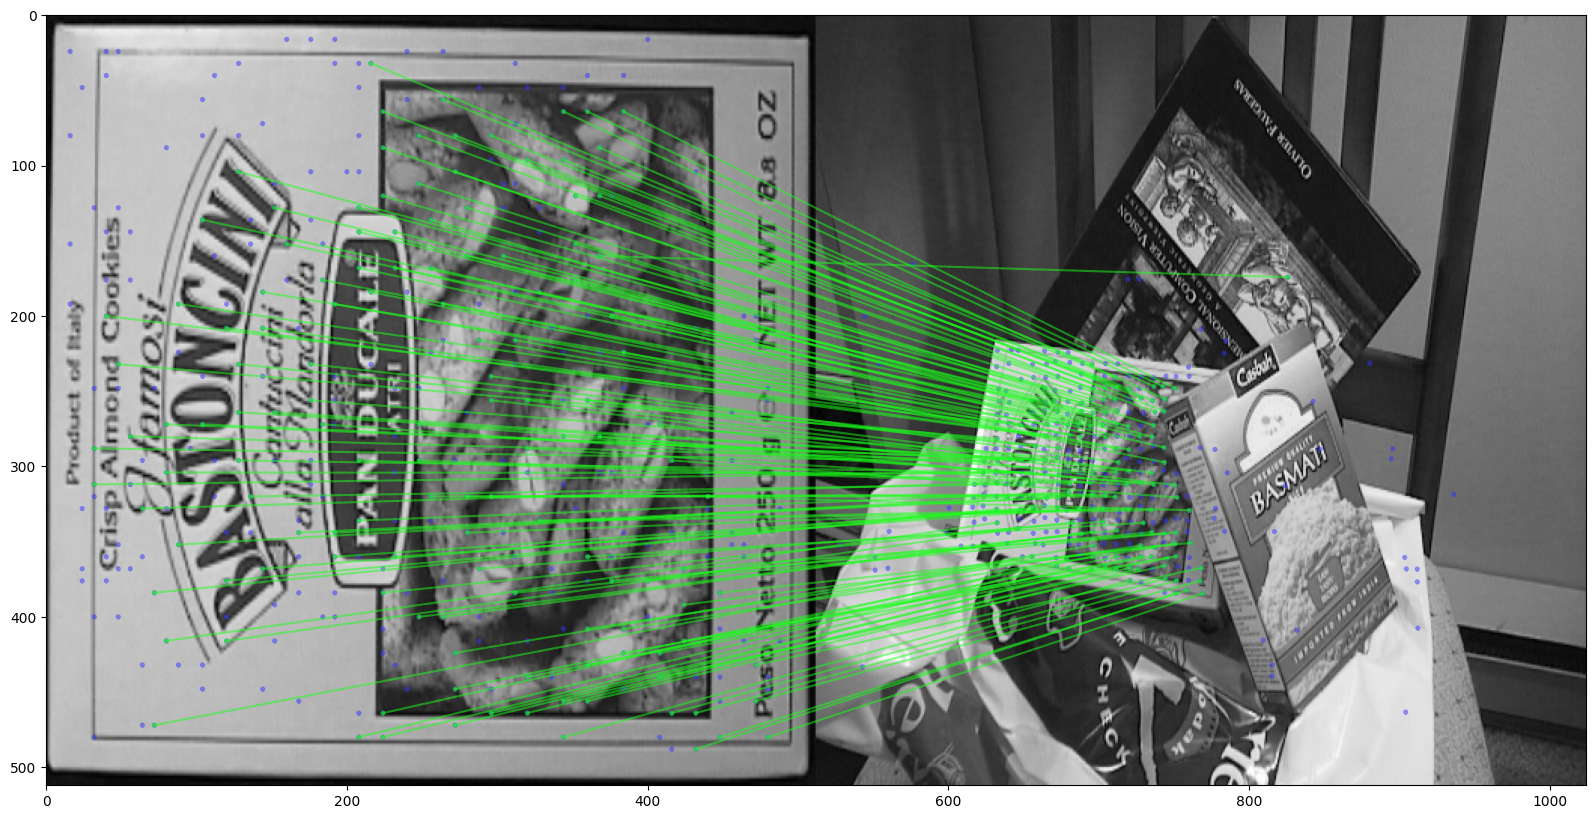

In [27]:
# Finally, we can visualize the matches
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={
        "inlier_color": (0.1, 1, 0.1, 0.5),
        "tentative_color": None,
        "feature_color": (0.2, 0.2, 1, 0.5),
        "vertical": False,
    },
)